### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

План занятия:

1. задача сегментации аудитории по интересам - для чего
2. тематическое моделирование - получаем эмбединги текстов
3. решаем downstream-задачу (профилирование аудитории новостного портала)

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

#### Задача сегментации (неформальное определение)

Разбиваем пользователей на группы, чем-то отличающиеся друг от друга

Если же более формально, то:

Сегментация клиентской базы — это способ повышения эффективности работы с пользователями путем их распределения по отдельным группам, или сегментам, в соответствии с их запросами и/или потребностями.

Сегментация может быть очень разной:

#### 1. когда совершил первую покупку (сколько прошло с момента регистрации до момента покупки)

![ab_split](payments1.png "Payments2")

#### 2. по психотипам

![ab_split](psycho.png "Psycho")

#### 3. по платежам

![ab_split](payments.png "Payments")

#### 4. По эффективности взаимодействия (uplift)

![ab_split](uplift.png "Uplift")

#### 5. по интересам

![ab_split](interests.png "Interests")

И еще 100500 вариантов сегментирования, которое может быть полезно. 

Для чего полезно?

1. понимание аудитории, способность описать основные группы пользователей и их интересы
2. выявление сегментов с максимальной монетизацией
3. выбор маркетинговой стратегии
4. налаживание эффективного взаимодействия с пользователями

#### Пример из жизни (новостной портал)

Представим, что мы - компания-агрегатор новостей (новостной портал).

У нас есть:

1. читатели
2. новости

Для каждого пользователя мы можем за какой-то период (например, 1 день) достать из базы данных список прочитанных им новостей.

Для каждой новости мы можем вытащить текст и метаинформацию.

### Задача #1: нужно построить модель прогнозирования оттока - это наша downstream-задача. 

Нам нужны:

1. векторное представление пользователя
2. сегменты, описывающие интересы пользователя

p.s. в контексте нашей задачи - это одно и то же

### С чего начнем?

С векторного представления и сегментов новостей!

Есть два очевидных варианта как это сделать:

1. многоклассовая классификация
2. кластеризация документов с последующей попыткой их (кластера) интерпретировать

Проблема:

1. для классификации нам нужно сначала разметить новости - привлечение ручного труда

### Задача тематического моделирования

#### Неформально!

- на свете бывают темы (заранее неизвестные), которые отражают то, о чём могут быть части документа;
- каждая тема – это распределение вероятностей на словах, т.е. мешок слов, из которого можно с разной вероятностью вытащить разные слова;
- каждый документ – это смесь тем, т.е. распределение вероятностей на темах, кубик, который можно кинуть;
- процесс порождения каждого слова состоит в том, чтобы сначала выбрать тему по распределению, соответствующему документу, а затем выбрать слово из распределения, соответствующего этой теме.

Вероятностные модели удобно понимать и представлять в виде порождающих процессов (generative processes), когда мы последовательно описываем, как порождается одна единица данных, вводя по ходу дела все вероятностные предположения, которые мы в этой модели делаем. Соответственно, порождающий процесс для LDA должен последовательно описывать, как мы порождаем каждое слово каждого документа. И вот как это происходит (здесь и далее я буду предполагать, что длина каждого документа задана – её тоже можно добавить в модель, но обычно это ничего нового не даёт):

1. для каждой темы t выбираем вектор phi_t - распределение слов в теме

2. для каждого документа d:

    2.1 выбираем Theta_d - распределение тем в документе
    
    2.2 для каждого из слов документа w:
        2.2.1 выбираем тему z~Theta_d
        2.2.2 выбираем слово w~p(w|z, phi)

![lda](lda_simple.png "LDA")

ист. https://habr.com/ru/company/surfingbird/blog/230103/

#### Чуть более формально

Терминология:

1. документ - коллекция слов 
2. тема - набор токенов (слов), совместно часто встречающихся в документах

Более формально:

1. тема - условное распределение на множестве терминов, p(w|t)
2. тематический профиль документа - условное распределение тем p(t|d)

Вопрос: что же нам дано (в терминах условной вероятности)?

Ответ: условное распределение слов в документах - p(w|d)

Прекрасное объяснение от Воронцова - http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf

Тематическая модель позволяет нам получить p(w|t), p(t|d) по известным p(w|d)

![ab_split](tm1.png "TM1")

### ПЕРЕРЫВ ДО 21:02 (МСК)

### Переходим к практике

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [6]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [7]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [8]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [9]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-8-7ee348d9b386>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 25 s


In [10]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 46s


А теперь в 3 строчки обучим нашу модель

In [11]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [12]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [13]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 44.6 s


In [14]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [15]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(2, 0.12117122),
 (3, 0.1631228),
 (4, 0.040569294),
 (7, 0.16912723),
 (8, 0.37029746),
 (10, 0.11875168)]

In [16]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: сон арбитраж ирландия аргентина показ сингапур норвегия
topic_1: это человек год который всё писать погибнуть
topic_2: экономика nn станция место миссия китай высота
topic_3: год университет век французский франция стать знаменитый
topic_4: население год страна который город россия государство
topic_5: ребёнок общество поверхность питание верхний продолжительность кость
topic_6: год который это мочь свой время исследование
topic_7: компания система это проект новый год рост
topic_8: это год очень который свой большой мочь
topic_9: эксперимент выяснить фестиваль медведев год мероприятие программа
topic_10: год млн тыс составить вырасти напомнить министерство
topic_11: суд убийство женщина статья мужчина следователь сотрудник
topic_12: банк область технология космос конкурс государственный депутат
topic_13: турецкий чиновник турция предприниматель употребление отряд ii
topic_14: рак смерть выяснить полиция египет задержать человек
topic_15: человек который это тело время результ

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [17]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [18]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.00000,0.0,0.078332,0.000000,0.090972,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.061927,0.000000,0.0
1,4896,0.08323,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.409594,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.485137,0.0
2,4897,0.00000,0.0,0.120980,0.163095,0.040651,0.000000,0.000000,0.169139,0.370378,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,4898,0.00000,0.0,0.000000,0.000000,0.000000,0.015794,0.516395,0.000000,0.295664,...,0.130126,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,4899,0.00000,0.0,0.000000,0.110398,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.063289,0.0,0.0,0.0,0.0,0.0,0.0,0.801828,0.000000,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [19]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [20]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [21]:
doc_dict[293622]

array([0.        , 0.14023012, 0.        , 0.06831513, 0.        ,
       0.        , 0.20153742, 0.        , 0.        , 0.        ,
       0.06278617, 0.        , 0.        , 0.05584941, 0.        ,
       0.15296058, 0.        , 0.02007935, 0.        , 0.12577313,
       0.        , 0.12194853, 0.04141564, 0.        , 0.        ])

In [28]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [29]:
get_user_embedding(user_articles_list)

array([0.00287471, 0.        , 0.02107017, 0.04848444, 0.        ,
       0.        , 0.00354843, 0.16638673, 0.09475275, 0.01718912,
       0.02195249, 0.        , 0.03572428, 0.        , 0.06231015,
       0.01033822, 0.07949414, 0.        , 0.0275167 , 0.0116779 ,
       0.        , 0.00246238, 0.        , 0.00560698, 0.37638005])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [30]:
#users['articles'].iloc[33]

In [31]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [32]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.017264,0.009894,0.000000,0.022101,0.000000,0.009666,0.017924,0.022132,0.040880,...,0.038504,0.197459,0.000000,0.019814,0.004643,0.051808,0.022799,0.0,0.006265,0.251613
1,u108690,0.002555,0.005133,0.001892,0.004279,0.004268,0.000000,0.029035,0.106010,0.101564,...,0.009839,0.109913,0.011592,0.062748,0.011922,0.005002,0.000000,0.0,0.013497,0.194434
2,u108339,0.000000,0.000000,0.031563,0.019371,0.000000,0.000000,0.046938,0.117726,0.009839,...,0.031235,0.171951,0.002553,0.035074,0.021898,0.024536,0.015052,0.0,0.005166,0.218716


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [33]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [34]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.017264,0.009894,0.000000,0.022101,0.000000,0.009666,0.017924,0.022132,0.040880,...,0.197459,0.000000,0.019814,0.004643,0.051808,0.022799,0.0,0.006265,0.251613,0
1,u108690,0.002555,0.005133,0.001892,0.004279,0.004268,0.000000,0.029035,0.106010,0.101564,...,0.109913,0.011592,0.062748,0.011922,0.005002,0.000000,0.0,0.013497,0.194434,1
2,u108339,0.000000,0.000000,0.031563,0.019371,0.000000,0.000000,0.046938,0.117726,0.009839,...,0.171951,0.002553,0.035074,0.021898,0.024536,0.015052,0.0,0.005166,0.218716,1


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [36]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [37]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [38]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.1241075 , 0.04667447, 0.39476045, 0.24006717, 0.01870613,
       0.05898215, 0.10911461, 0.06375848, 0.1687945 , 0.23882364])

In [32]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [40]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.257658, F-Score=0.703, Precision=0.645, Recall=0.771


In [44]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1651  104]
 [  57  188]]


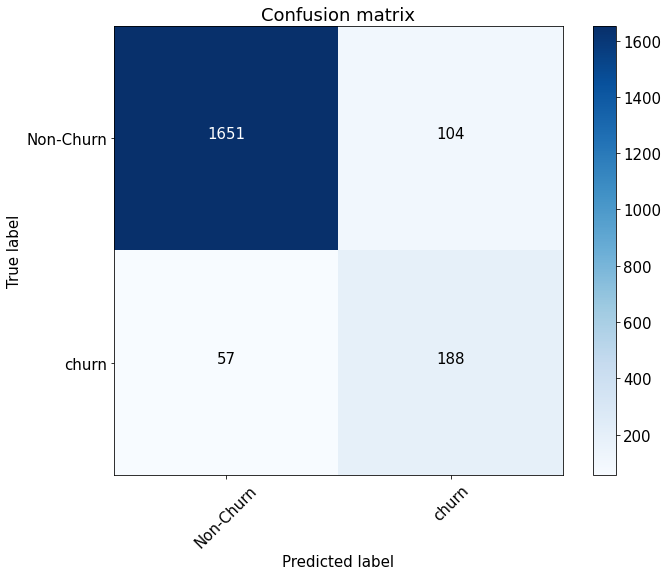

In [45]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [46]:
roc_auc_score(y_test, preds)

0.9525995697424268

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

#### Задание 2
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

#### Задание 3
Повторить п.2, но используя уже не медиану, а max

In [22]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

def get_user_embedding_median(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

def get_user_embedding_max(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

In [23]:
get_user_embedding(user_articles_list)
get_user_embedding_median(user_articles_list)
get_user_embedding_max(user_articles_list)

array([0.        , 0.2823714 , 0.01373236, 0.03421976, 0.21340925,
       0.03661259, 0.44668391, 0.18001142, 0.16866365, 0.        ,
       0.04115354, 0.17227307, 0.        , 0.        , 0.04973968,
       0.05459406, 0.05366624, 0.13572305, 0.01311047, 0.32522693,
       0.        , 0.17240156, 0.38714042, 0.43699557, 0.        ])

In [24]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]


user_embeddings_meadian = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x), 1)])
user_embeddings_meadian.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_meadian['uid'] = users['uid'].values
user_embeddings_meadian = user_embeddings_meadian[['uid']+['topic_{}'.format(i) for i in range(25)]]


user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x), 1)])
user_embeddings_max.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+['topic_{}'.format(i) for i in range(25)]]

In [25]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [26]:
X = pd.merge(user_embeddings, target, 'left')
X_2 = pd.merge(user_embeddings_meadian, target, 'left')
X_3 = pd.merge(user_embeddings_max, target, 'left')

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [28]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_2['churn'], random_state=0)
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3[['topic_{}'.format(i) for i in range(25)]], 
                                                    X_3['churn'], random_state=0)

In [29]:
logreg = LogisticRegression()
logreg_2 = LogisticRegression()
logreg_3 = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)
logreg_2.fit(X_2_train, y_2_train)
logreg_3.fit(X_3_train, y_3_train)

LogisticRegression()

In [30]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

preds_2 = logreg_2.predict_proba(X_2_test)[:, 1]
preds_2[:10]

preds_3 = logreg_3.predict_proba(X_3_test)[:, 1]
preds_3[:10]

array([0.16720237, 0.00362363, 0.85552621, 0.13182462, 0.0034685 ,
       0.01810132, 0.07621886, 0.01527429, 0.01186595, 0.25981658])

### Рассчитаем Precision, Recall, F_score для median, max

In [33]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.233232, F-Score=0.698, Precision=0.612, Recall=0.812


In [34]:
precision_2, recall_2, thresholds_2 = precision_recall_curve(y_2_test, preds_2)
fscore_2 = (2 * precision_2 * recall_2) / (precision_2 + recall_2)
# locate the index of the largest f score
ix_2 = np.argmax(fscore_2)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_2[ix_2], 
                                                                        fscore_2[ix_2],
                                                                        precision_2[ix_2],
                                                                        recall_2[ix_2]))

Best Threshold=0.363623, F-Score=0.789, Precision=0.864, Recall=0.727


In [35]:
precision_3, recall_3, thresholds_3 = precision_recall_curve(y_3_test, preds_3)
fscore_3 = (2 * precision_3 * recall_3) / (precision_3 + recall_3)
# locate the index of the largest f score
ix_3 = np.argmax(fscore_3)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_3[ix_3], 
                                                                        fscore_3[ix_3],
                                                                        precision_3[ix_3],
                                                                        recall_3[ix_3]))

Best Threshold=0.353773, F-Score=0.798, Precision=0.805, Recall=0.792


In [36]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1629  126]
 [  47  198]]


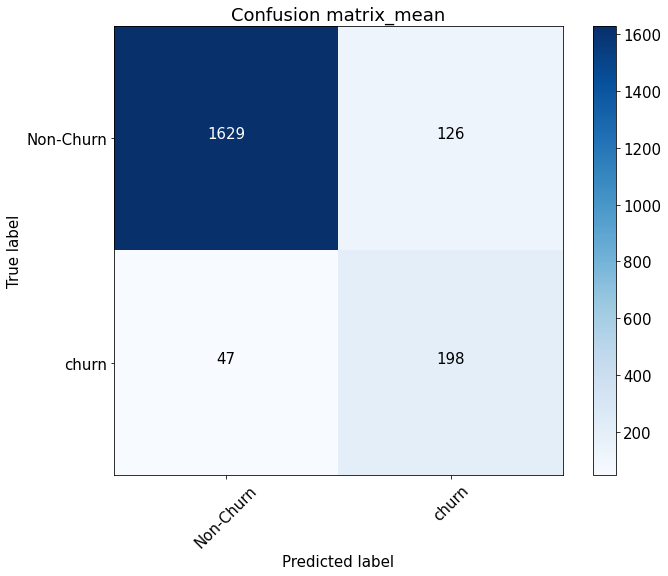

In [37]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_mean')
plt.savefig("conf_matrix.png")
plt.show()

In [38]:
roc_auc_score(y_test, preds)

0.9536647479504622

Confusion matrix, without normalization
[[1727   28]
 [  68  177]]


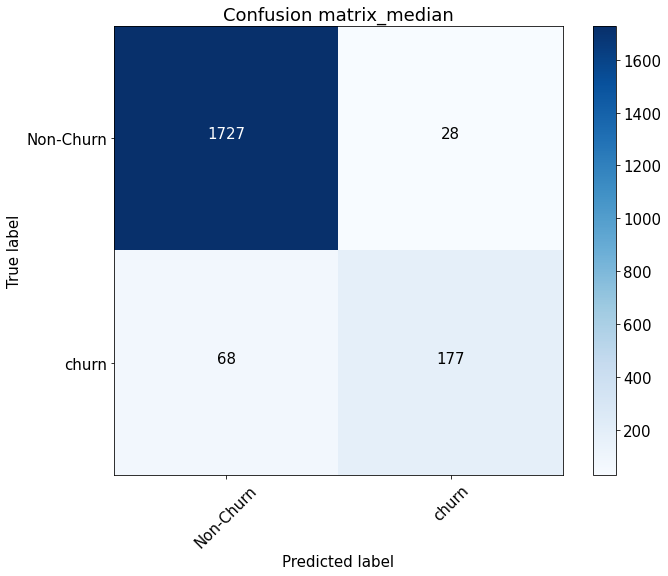

In [39]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_2_test, preds_2>thresholds_2[ix_2])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_median')
plt.savefig("conf_matrix.png")
plt.show()

In [40]:
roc_auc_score(y_2_test, preds_2)

0.9768684225827082

Confusion matrix, without normalization
[[1708   47]
 [  52  193]]


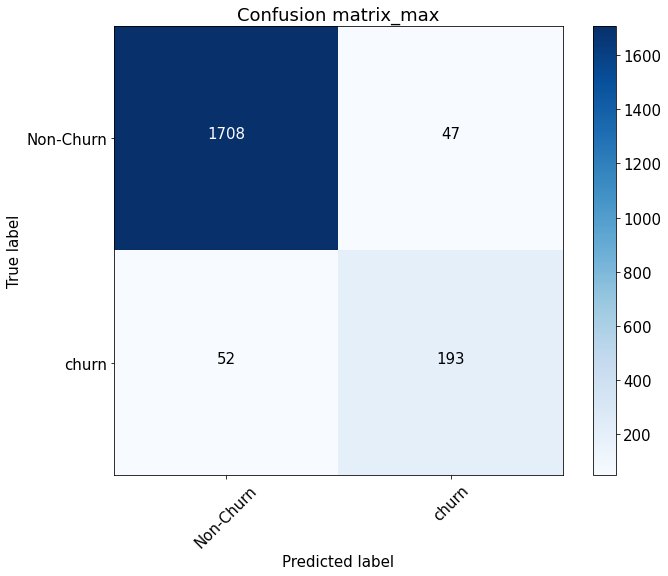

In [41]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_3_test, preds_3>thresholds_3[ix_3])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix_max')
plt.savefig("conf_matrix.png")
plt.show()

In [42]:
roc_auc_score(y_3_test, preds_3)

0.9745845688702832

#### 5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [43]:
result = [[precision[ix], recall[ix], thresholds[ix], fscore[ix]],\
          [precision_2[ix_2], recall_2[ix_2], thresholds_2[ix_2],fscore_2[ix_2]],\
          [precision_3[ix_3], recall_3[ix_3], thresholds_3[ix_3],fscore_3[ix_3]]]

names_col = ["precision","recall","thresholds","f-score"]
names_lines = ["mean","median","max"]
df = pd.DataFrame(result, index=names_lines, columns=names_col)
df

,precision,recall,thresholds,f-score
mean,0.612308,0.812245,0.233232,0.698246
median,0.864078,0.726531,0.363623,0.789357
max,0.804979,0.791837,0.353773,0.798354


#### Задание 6:
Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Наиболее точный результат получился с критерием max, на втором месте медиана и на 3-ем среднее значение.
У медианы точность упала поскольку в векторе большое кол-во 0, но распределение лучше чем по среднему.
При максимуме попали самые весомые значения, что привело к повышению точности.